# $$ \text{Data Collection} $$

## Import Libraries & Utils

In [1]:
from common.openalex_collect import fetch_openalex
from common.utils import write_partitioned_by_year
import pandas as pd
import numpy as np
from pathlib import Path
import yaml, re, json, time

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8"); sns.set_theme(style="whitegrid")

## Load Configs

In [14]:
config_url = "configs/collect_config.yaml"

with open(config_url, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

config

{'year_from': 2010,
 'year_to': 2025,
 'max_per_year': 500,
 'per_page': 200,
 'sleep_sec': 3.0,
 'paths': {'raw': '/opt/data/raw'}}

## Collect

In [4]:
df = fetch_openalex(config["year_from"], config["year_to"], config["per_page"], config["max_per_year"], config["sleep_sec"])

## EDA

In [5]:
print("Shape:", df.shape)
print("Columns:", df.columns)

Shape: (8000, 9)
Columns: Index(['id', 'title', 'abstract', 'year', 'authors', 'keywords_gold',
       'doc_text', 'n_tokens', 'uid'],
      dtype='object')


In [6]:
display(df.head())

,id,title,abstract,year,authors,keywords_gold,doc_text,n_tokens,uid
0,W2092157292,A consistent and accurate<i>ab initio</i>param...,The method of dispersion correction as an add-...,2010,"[Stefan Grimme, Jens Antony, Stephan Ehrlich, ...","[Density functional theory, Dispersion (optics...",A consistent and accurate<i>ab initio</i>param...,315,8f85584b604658070ab0332934846d039a69b957
1,W2072970694,QIIME allows analysis of high-throughput commu...,,2010,"[J. Gregory Caporaso, Justin Kuczynski, Jesse ...","[Throughput, DNA sequencing, Computational bio...",QIIME allows analysis of high-throughput commu...,8,c04004f9c3899c5c300fa2558c64efdc8a501824
2,W2289205268,Como Elaborar Projetos de Pesquisa,Elaborar um projeto de pesquisa para conferir ...,2010,[Antônio Carlos Gil],"[Humanities, Philosophy, Political science, Co...",Como Elaborar Projetos de Pesquisa\n\nElaborar...,139,30e01f062dafb04207c4bea498b99f61d9d127e6
3,W2119180969,The Genome Analysis Toolkit: A MapReduce frame...,"Next-generation DNA sequencing (NGS) projects,...",2010,"[Aaron McKenna, Matthew G. Hanna, Eric Banks, ...","[Computer science, Genome, Correctness, 1000 G...",The Genome Analysis Toolkit: A MapReduce frame...,248,c7357b23516fd0225161f4e5cd5032c0e9e6939a
4,W2124026197,Features and development of <i>Coot</i>,Coot is a molecular-graphics application for m...,2010,"[Paul Emsley, Bernhard Lohkamp, W. G. Scott, K...","[Computer science, Scripting language, Softwar...",Features and development of <i>Coot</i>\n\nCoo...,163,e09fa45036d9fa35b3309ff6867e05637a96d9a0


In [7]:
print("Dtypes:\n", df.dtypes)
print("Missing values per columns:\n", df.isna().sum())

Dtypes:
 id               object
title            object
abstract         object
year              int64
authors          object
keywords_gold    object
doc_text         object
n_tokens          int64
uid              object
dtype: object
Missing values per columns:
 id               0
title            0
abstract         0
year             0
authors          0
keywords_gold    0
doc_text         0
n_tokens         0
uid              0
dtype: int64


In [8]:
def _list_len(x):
    return len(x) if isinstance(x, list) else 0

N = len(df)
quality = {
    "n_papers": N,
    "pct_empty_title": round(100*(df["title"].fillna("").str.strip()=="").mean(), 2),
    "pct_empty_abstract": round(100*(df["abstract"].fillna("").str.strip()=="").mean(), 2),
    "pct_empty_doc_text": round(100*(df["doc_text"].fillna("").str.strip()=="").mean(), 2),
    "pct_empty_keywords_gold": round(100*(df["keywords_gold"].apply(_list_len)==0).mean(), 2),
    "tokens_min": int(df["n_tokens"].min()) if N else 0,
    "tokens_p50": int(df["n_tokens"].median()) if N else 0,
    "tokens_p95": int(df["n_tokens"].quantile(0.95)) if N else 0,
    "tokens_max": int(df["n_tokens"].max()) if N else 0
}

pd.DataFrame([quality])

,n_papers,pct_empty_title,pct_empty_abstract,pct_empty_doc_text,pct_empty_keywords_gold,tokens_min,tokens_p50,tokens_p95,tokens_max
0,8000,0.01,37.51,0.0,1.55,1,85,304,4193


In [9]:
df["doc_text_len"] = df["doc_text"].fillna("").astype(str).str.len()
df["kw_gold_len"] = df["keywords_gold"].apply(_list_len)

display(df[["n_tokens", "doc_text_len", "kw_gold_len"]].describe())

print("Papers with empty keywords_gold:", (df["kw_gold_len"]==0).sum(), "/", len(df))

,n_tokens,doc_text_len,kw_gold_len
count,8000.000000,8000.000000,8000.000000
mean,115.330500,817.508625,11.291250
std,162.932856,1124.692701,4.894632
min,1.000000,3.000000,0.000000
25%,10.000000,80.000000,8.000000
50%,85.000000,605.500000,12.000000
75%,186.000000,1307.250000,15.000000
max,4193.000000,29959.000000,26.000000


Papers with empty keywords_gold: 124 / 8000


Saved EDA summary plot to /opt/data/raw/eda_summary.png


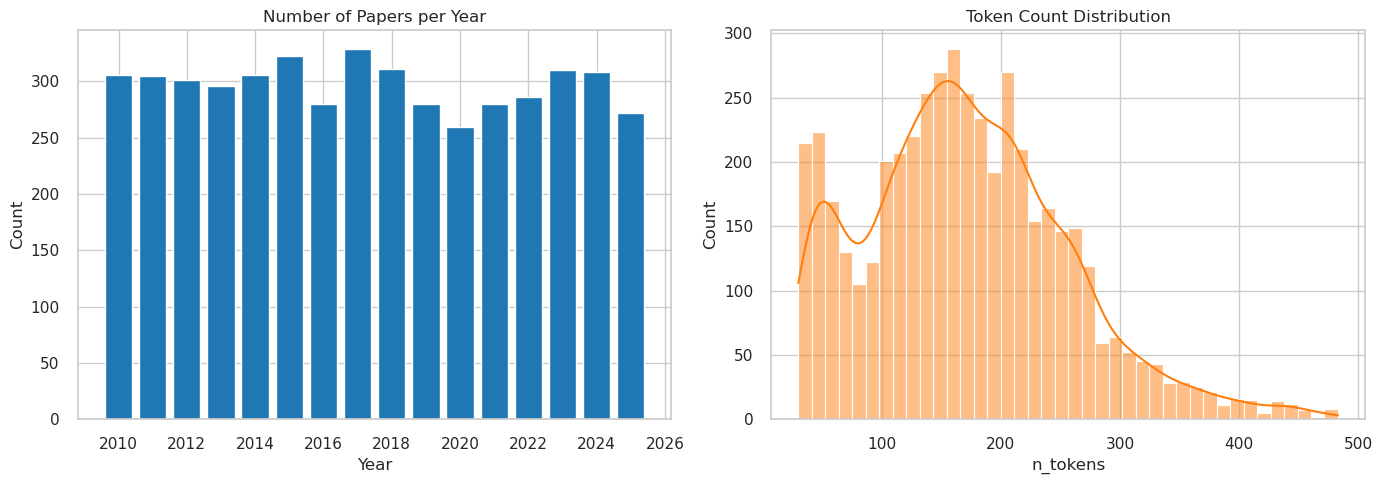

In [15]:
summary_dir = Path(config["paths"]["raw"])
summary_dir.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
year_counts = df.groupby("year").size().sort_index()
axes[0].bar(year_counts.index, year_counts.values, color="#1f77b4")
axes[0].set_title("Number of Papers per Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count")

sns.histplot(df["n_tokens"], bins=40, ax=axes[1], kde=True, color="#ff7f0e")
axes[1].set_title("Token Count Distribution")
axes[1].set_xlabel("n_tokens")

plt.tight_layout()
fig_path = summary_dir / "eda_summary.png"
plt.savefig(fig_path, dpi=120)
print("Saved EDA summary plot to", fig_path)

In [16]:
df_before = df.copy()

MIN_TOK = 30
MAX_TOK = int(df["n_tokens"].quantile(0.99))

mask = (
    (df["doc_text"].fillna("").str.strip() != "") &
    (df["n_tokens"] >= MIN_TOK) &
    (df["n_tokens"] <= MAX_TOK)
)

df = df.loc[mask].copy()
df_reject = df_before.loc[~mask].copy()

print("Before:", df_before.shape, "After:", df.shape, "Rejected:", df_reject.shape)
display(df_reject[["uid","year","n_tokens","title"]].head(5))

Before: (4753, 13) After: (4705, 13) Rejected: (48, 13)


,uid,year,n_tokens,title
144,6ae5f816735f3296c036e8d1fccd70c7c55a027f,2010,452,CRC Handbook of Thermoelectrics
161,04f5019ef9b02fa366764e131c5880e07786061c,2010,432,Qualitative Research from Start to Finish
176,9d92fb48c9d29c5731fabee50e216ce1e959750e,2010,474,The NCEP Climate Forecast System Reanalysis
440,e5301d0a3aa7b21030e07cfc9f2ebb460bcaa1aa,2010,483,Global fire emissions and the contribution of ...
564,7acd34b99397fe172f47e788b334258731be37a6,2011,434,Quantity and Quality of Exercise for Developin...


In [17]:
N = len(df)
print("After filtering:")
print("  years:", int(df["year"].min()), "->", int(df["year"].max()))
print("  tokens p50/p95:", int(df["n_tokens"].median()), int(df["n_tokens"].quantile(0.95)))
print("  empty keywords_gold (%):", round(100*(df["keywords_gold"].apply(_list_len)==0).mean(), 2))

After filtering:
  years: 2010 -> 2025
  tokens p50/p95: 163 312
  empty keywords_gold (%): 1.68


In [18]:
def sliver_from_title(title: str):
    if not isinstance(title, str):
        return []
    s = title.lower().strip()
    s = re.sub(r"[^a-z0-9\s\-]", " ", s)
    s = re.sub(r"[\u2010-\u2015\-_/]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()

    toks = [t for t in s.split() if len(t) >= 3]
    bigrams = [" ".join(toks[i:i+2]) for i in range(len(toks)-1)]

    out = bigrams[:10] + toks[:10]
    seen = set()
    uniq = []

    for x in out:
        if x not in seen:
            seen.add(x)
            uniq.append(x)
    return uniq

df["silver_title"] = df["title"].apply(sliver_from_title)
df["silver_len"] = df["silver_title"].apply(len)

display(df[["silver_title"]].describe())
display(df[["title", "silver_title"]].head(5))

,silver_title
count,4705
unique,4612
top,"[review particle, particle physics, review, pa..."
freq,8


,title,silver_title
0,A consistent and accurate<i>ab initio</i>param...,"[consistent and, and accurate, accurate initio..."
2,Como Elaborar Projetos de Pesquisa,"[como elaborar, elaborar projetos, projetos pe..."
3,The Genome Analysis Toolkit: A MapReduce frame...,"[the genome, genome analysis, analysis toolkit..."
4,Features and development of <i>Coot</i>,"[features and, and development, development co..."
5,BEDTools: a flexible suite of utilities for co...,"[bedtools flexible, flexible suite, suite util..."


## Store

In [19]:
raw_dir = Path(config["paths"]["raw"])
raw_dir.mkdir(parents=True, exist_ok=True)

manifest = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "config": config,
    "n_papers": int(len(df)),
    "years": {"min": int(df["year"].min()), "max": int(df["year"].max())},
    "n_tokens": {
        "min": int(df["n_tokens"].min()),
        "p50": int(df["n_tokens"].median()),
        "p95": int(df["n_tokens"].quantile(0.95)),
        "max": int(df["n_tokens"].max()),
    },
    "pct_empty_keywords_gold": float((df["keywords_gold"].apply(_list_len)==0).mean()),
    "pct_empty_silver_title": float((df["silver_title"].apply(_list_len)==0).mean()),
    "columns": list(df.columns),
}

manifest_path = raw_dir / "_manifest.json"
manifest_path.write_text(json.dumps(manifest, ensure_ascii=False, indent=2), encoding="utf-8")
print("Wrote:", manifest_path)

Wrote: /opt/data/raw/_manifest.json


In [20]:
write_partitioned_by_year(df, config["paths"]["raw"])

---